# Drug Discovery

This is a demo to explore potential drugs on [A single-cell atlas of the peripheral immune response in patients with severe COVID-19 data](https://www.nature.com/articles/s41591-020-0944-y) based on BRICK.

## Load packages and data

In [1]:
import sklearn
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

Graph database has been configured and initialized successfully.


In [2]:
adata = sc.read('./data/Neutrophil_adata_sub.h5ad')
adata

AnnData object with n_obs × n_vars = 301 × 292
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'singler'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'rank_genes_groups', 'rank_genes_groups_df', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'matrix', 'norm_data', 'scale_data'

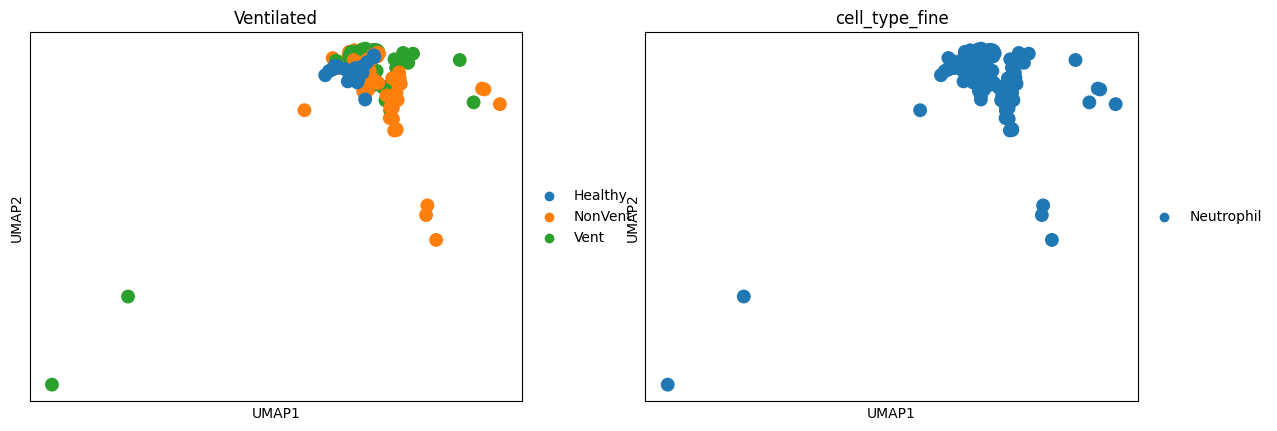

In [3]:
sc.pl.umap(adata, color = ['Ventilated', 'cell_type_fine'])

## Differential Expression Gene analysis

Here we take **Neutrophil** as example and calculate diffferential expression gene both on celltype and cell state. With top DEG number as 100, the final Geneset is composed of 100 DEG for Healthy, NonVert and Vent in CD14 monocyte respectively.

In [4]:

N_top_genes = 100

geneset = set()

# 100 DEG from different cell state of monocyte

sc.tl.rank_genes_groups(adata, 'Ventilated')
BRICK.pp.rank_genes_groups2df(adata)
for cell_state in adata.uns['rank_genes_groups_df'].values():
    for x in list(cell_state['names'])[:N_top_genes]:
        geneset.add(x)

print(len(geneset))

292


## Query Knowledge Graph

this might some time because gene might related to many entities.

In [5]:
df = BRICK.qr.query_neighbor(geneset, source_entity_type='Gene',
                             target_entity_type=['Disease','Phenotype',
                                                 'Process','Cell_Component','Pathway', 'Function',
                                                 'Tissue','Cell',
                                                 'Chemical','Stage'], return_type='triplet')

## Filter target entity 
by pvalue with cut-off as 0.01

In [9]:
df_count = BRICK.rk.enrich(df)
df_count_filtered = df_count.loc[df_count['path.2.enrich_pvalue'] < 0.0001]
df_count_filtered.head()

,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,path.2.enrich_statistic,path.2.enrich_pvalue
25,"[ISG15, CD36, CD163, KLF4, CD83, SOCS3, MBD2, TNFSF10, BTG2, SF1, THBS1, SORL1, SOD2, NCF1, RBL2, PTEN, OAS1, NFKBIA, NCF2, MX1, MEF2A, MCL1, JUND, JUNB, JUN, IL6R, IGF2R, IFIT1, IDH1, HLA-C, HBA2, MYLIP, GPX1, FPR1, FOSB, FOS, NLRP1, ACSL1, SERPINB1, EGR1, EEF1A1, DUSP1, VCAN, MAPK14, TXNIP, IFI44, CDKN1A, DHRS9, LUCAT1, SOD2]",CHEBI:4806,(-)-epigallocatechin 3-gallate,Chemical,49,1788,2.000359,0.000029
86,"[H6PD, CD36, PPIG, SAT1, THBS1, SOD2, NCF1, PTEN, NFKBIA, NCF2, NAGA, MCL1, MARCKS, JUND, JUNB, JUN, HBB, HBA2, SLC25A6, GPX1, FPR1, FOSB, FOS, ALDH2, EEF2, EEF1A1, MAPK14, TXNIP, AKR1A1, CDKN1A, NBPF10]",CHEBI:58968,(E)-4-hydroxynon-2-enal,Chemical,31,914,2.475682,0.000018
93,"[JUND, JUNB, JUN, FOSB, FOS]",CHEBI:28985,"(R)-1,2-epoxypropane",Chemical,5,13,28.074116,0.000004
136,"[KLF4, PTEN, JUND, JUNB, JUN, FOSB, FOS, CDKN1A]",CHEBI:34019,(S)-ATPA,Chemical,8,82,7.121239,0.000036
170,"[H6PD, PPIG, CD163, VNN1, TNFSF10, LAP3, THBS1, TGFBI, SOD2, SELL, S100A8, RPS4X, RPLP1, PROK2, PTEN, B2M, EIF2AK2, PER1, MBP, JUN, CXCR2, IL6R, IL4R, IDH1, HLX, HLA-DRB1, HLA-DRA, HLA-C, HLA-B, HBA2, GPX1, IL17RA, FOS, FCGR3A, FCGR3A, FCGR2A, OTUD1, EEF1A1, CST3, VCAN, MAPK14, CCR1, TXNIP, IVNS1ABP]",MMUSDV:0000045,1 week,Stage,43,1558,2.014561,0.000066


## Construct Graph 
Construct Graph with adata and queried df from Knowledge Graph

In [13]:
nxg = BRICK.pp.combine_graph(adata[:, list(geneset)], df_count_filtered)

print(len(nxg.nodes))

adata.X seems not a sparse matrix, please check whether the adata.X is raw count or log normalized count
1619


## Model training


In [14]:
model = BRICK.emb.GRACE_model(nxg, device='cpu')

(T):   0%|                                                                                    | 0/1000 [00:00<?, ?it/s]D:\Anaconda\envs\py310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
(T): 100%|██████████████████████████████████████████████████████████████| 1000/1000 [05:06<00:00,  3.27it/s, loss=6.34]


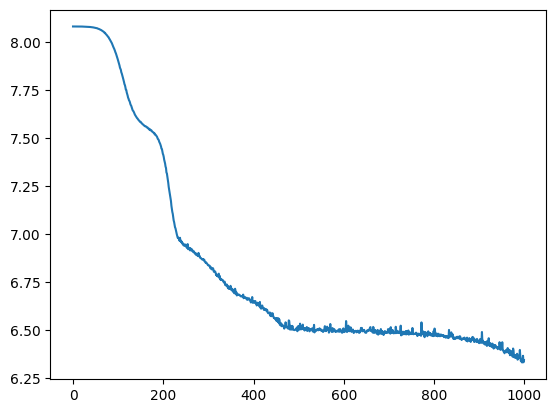

In [15]:
model.fit(epoches=1000)
model.plot_loss()

In [16]:
adata_graph = model.get_result()
adata_graph

D:\Anaconda\envs\py310\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1619 × 32
    obs: 'name', 'type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

##  Visualize Unite embedding result

In [18]:
cell2celltype = dict(zip(adata.obs_names, adata.obs['Ventilated']))
adata_graph.obs['cellstate'] = [cell2celltype[x] if x in cell2celltype else y for x, y in zip(adata_graph.obs['name'], adata_graph.obs['type'])]

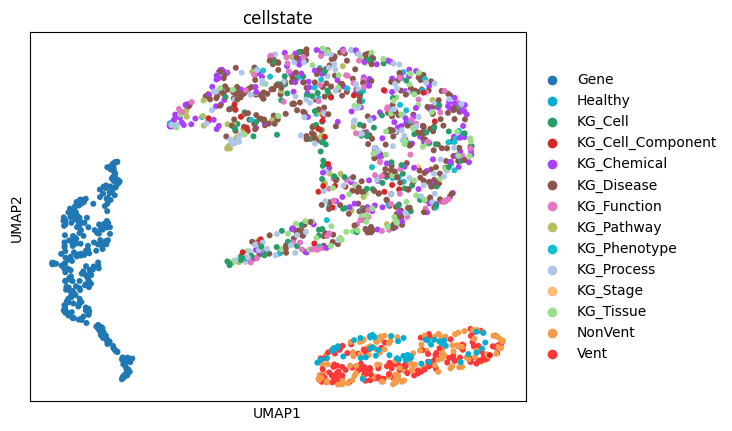

In [19]:
adata_graph.uns['cellstate_colors'] = ['#1f77b4','#06add2','#279e68','#d62728','#aa40fc',
                                       '#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8',
                                       '#ffbb78','#98df8a','#f39b4a','#FB3737']

sc.pl.umap(adata_graph, color = 'cellstate')

## rank chemicals related to COVID-19

In [20]:
disease_name = 'COVID-19'

from sklearn.metrics.pairwise import cosine_similarity
adata_graph_chemical = adata_graph[adata_graph.obs['type'] == 'KG_Chemical']
adata_graph_disease = adata_graph[adata_graph.obs['name'] == disease_name]


emb1 = adata_graph_chemical.X
emb2 = adata_graph_disease.X
dist = cosine_similarity(emb1, emb2)

df_drug = adata_graph_chemical.obs.copy()
df_drug['cosine_similiarity'] = dist
df_drug = df_drug[['cosine_similiarity']].sort_values('cosine_similiarity', ascending=False)



In [21]:
df_drug = adata_graph_chemical.obs.copy()
df_drug['cosine_similiarity'] = dist
df_drug = df_drug[['cosine_similiarity']].sort_values('cosine_similiarity', ascending=False)

In [22]:
df_drug

,cosine_similiarity
name,
Sodium,0.999458
Glycine,0.999389
Adenosine Monophosphate,0.999235
Sirolimus,0.998716
Superoxides,0.998582
Phosphatidylinositols,0.998559
Androgens,0.998254
NADPH(4-),0.997837
glutathionate(1-),0.996940


## Compare predicted potential drugs with real drug for COVID-19

query real drug for COVID-19

In [33]:
real_drug = BRICK.qr.query_neighbor(['COVID-19'], source_entity_type='Disease', target_entity_type='Chemical', relation='pharmaco_effect_on')

In [35]:
real_drug_list = list(real_drug["path.2.name"])

In [36]:
df_drug['is_real_drug'] = [x in real_drug_list for x in df_drug.index]

df_drug.head(15)

,cosine_similiarity,is_real_drug
name,,
Sodium,0.999458,False
Glycine,0.999389,True
Adenosine Monophosphate,0.999235,False
Sirolimus,0.998716,True
Superoxides,0.998582,False
Phosphatidylinositols,0.998559,False
Androgens,0.998254,True
NADPH(4-),0.997837,False
glutathionate(1-),0.996940,False


In [37]:
BRICK.config_llm(modeltype='ChatOpenAI', 
                 api_key="sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55",  
                 base_url='http://10.224.28.80:3000/v1', 
                 llm_params={'model_name': 'qwen-max'})

LLM has been configured and initialized successfully.


In [38]:
print(BRICK.inp.drug_repurposing_analysis(adata_graph=adata_graph, df_real_drug=real_drug, disease_name='COVID-19'))

### Interpretation of Drug Repurposing Results for COVID-19

#### Summary of Evidenced Drugs
Based on the `evidenced_drug` column in Table 1, the following drugs have been identified as having evidence for use in treating COVID-19:
- **Glycine**: Amino acid with potential anti-inflammatory and immunomodulatory properties.
- **Sirolimus**: An immunosuppressive agent that may help modulate the immune response.
- **Androgens**: Hormones that can influence the immune system and inflammation.
- **Dexamethasone**: A corticosteroid that has shown efficacy in reducing mortality in severely ill COVID-19 patients.
- **Tretinoin**: A retinoid used in dermatology, which may have some anti-inflammatory effects.
- **Melatonin**: A hormone that regulates sleep and has antioxidant and anti-inflammatory properties.
- **Resveratrol**: A polyphenol with antioxidant and anti-inflammatory effects.
- **Hydrocortisone**: Another corticosteroid that can reduce inflammation.
- **Chloroquine**: An antimalarial 